In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import base64
import binascii
from ipaddress import ip_address
import tldextract
from urllib.parse import urlparse
import numpy as np
import csv
warnings.filterwarnings('ignore')

In [2]:
class Sample:
    
    def __init__(self, url: str, phishing: bool = True, ):
        self.url = url
        self.parsed_url = urlparse(url)
        self.phishing = phishing

def amount_of_separators(sample: Sample) -> int:

    url_part02 = sample.parsed_url._replace(scheme="", netloc="")
    url_part02 = url_part02.geturl()
    return url_part02.count("-") 

def encoded_exploit(sample: Sample) -> int:
    try:
        int(sample.parsed_url.netloc, 16)
        return 1
    except ValueError:
        try:
            base64.b64decode(sample.parsed_url.netloc.encode(), validate=True)
            return 1
        except binascii.Error:
            return 0

domainename = []
# use encoding UTF8 because the file qnt lot of encoding types ...
# add newline comme separteur and
with open("C:\\Users\\Amine\\Desktop\\files\\projectA\\pyphish\\data\\tld.csv", newline="", encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile, delimiter=" ")
    for row in reader:
        domainename.append(row[0].lower())

def homographic_attack(sample: Sample) -> int:
    domains = sample.parsed_url.netloc.split(".")
    bl = True
    i = 1
    while i <= len(domains) - 1 and bl == True:
        if domains[i].lower() in domainename:
            bl = True
        else:
            bl = False
        i += 1
    return 1 if bl else 0

def http_with_specification_port(sample: Sample) -> int:
    if sample.parsed_url.scheme.upper() == "HTTP":
        if sample.parsed_url.port != 80 and sample.parsed_url.port is not None:
            return 1
    elif sample.parsed_url.scheme.upper() == "HTTPS":
        if sample.parsed_url.port != 443 and sample.parsed_url.port is not None:
            return 1
    return 0

def ip_address_explosure(sample: Sample) -> int:
    try:
        ip_address(sample.parsed_url.netloc)
        return 1
    except ValueError:
        return 0

def nb_sub_domain(sample: Sample) -> int:
    url = sample.url
    if "www." in url:
        url = url.replace("www.", "", 1)
    ext = tldextract.extract(url)
    subdomain = ext.subdomain.split(".")
    if "" in subdomain:
        nbsub = 0
    else:
        nbsub = len(subdomain)
    return nbsub 

shorteners = []
with open("C:\\Users\\Amine\\Desktop\\files\\projectA\\pyphish\\data\\shorteners.csv", encoding="utf-8", newline="") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        shorteners.append(row[0])
def shortened_url(sample: Sample) -> int:
    return 1 if sample.parsed_url.netloc in shorteners else 0


def tunneling_protocol(sample: Sample) -> int:
    return 0 if sample.parsed_url.scheme == "https" else 1


def url_size(sample: Sample) -> int:
    if len(sample.url) < 60:
        result = -1
    elif ((len(sample.url) > 60) & (len(sample.url) < 80)):
        result = 0
    else:
        result = 1
    return len(sample.url)


def url_with_redirection(sample: Sample) -> int:
    url = sample.parsed_url
    # r = requests.get(url)
    path = url.path
    query = url.query

    if ("//" in path) or (("//") in query):

        return 1
    else:
        return 0

def url_with_variable(sample: Sample) -> int:
    splited_url = sample.parsed_url.path.split("/")
    splited_url[:] = (value for value in splited_url if value != "")
    if len(splited_url) > 3:
        return 1

    else:
        return 0
    



In [3]:
def featureExtraction(sample:Sample ,label=None):
    features = []
    #Address bar based features (11)
    features.append(encoded_exploit(sample))
    features.append(amount_of_separators(sample))
    features.append(homographic_attack(sample))
    features.append(http_with_specification_port(sample))
    features.append(ip_address_explosure(sample))
    features.append(nb_sub_domain(sample))
    features.append(shortened_url(sample))
    features.append(tunneling_protocol(sample))
    features.append(url_size(sample))
    features.append(url_with_redirection(sample))
    features.append(url_with_variable(sample))
    features.append(label)
    return features

In [4]:
def urlTypePredict(sample: Sample,model):
    x=np.array(featureExtraction(sample))[1:-1].reshape(1,-1)
    result=model.predict(x)[0]
    return 'Legitimate' if result==0 else 'Phishing'

In [5]:
phishing = pd.read_csv(r"C:\Users\Amine\Desktop\Nouveau dossier\Train\url_2016_phishing.csv",names=['URL'],nrows=4000)
phishing['label']=1
legitimate=pd.read_csv(r"C:\Users\Amine\Desktop\Nouveau dossier\Train\url_2016_legitimate.csv",names=['URL'],nrows=5000)
legitimate['label']=0
phishing.shape

(4000, 2)

In [6]:
print (phishing.shape)
phishing.head()

(4000, 2)


URL  label
0  http://v2.email-marketing.adminsimple.com/trac...      1
1  http://bid.openx.net/json?amp;amp;amp;amp;cid;...      1
2  http://webmail2.centurytel.net/hwebmail/servic...      1
3  http://www.google.com.ng/imgres?imgurl=http://...      1
4  http://webmail2.centurytel.net/hwebmail/servic...      1

In [7]:
print (legitimate.shape)
legitimate.head()

(5000, 2)


URL  label
0  http://1337x.to/torrent/1048648/American-Snipe...      0
1  http://1337x.to/torrent/1110018/Blackhat-2015-...      0
2  http://1337x.to/torrent/1122940/Blackhat-2015-...      0
3  http://1337x.to/torrent/1124395/Fast-and-Furio...      0
4  http://1337x.to/torrent/1145504/Avengers-Age-o...      0

In [8]:
leg=pd.read_csv(r"C:\Users\Amine\Desktop\Nouveau dossier\Train\leg.csv",names=['URL','label'],header=0)
phish=pd.read_csv(r"C:\Users\Amine\Desktop\Nouveau dossier\Train\phish.csv",names=['URL','label'],header=0,nrows=1000)
#phish=pd.read_csv(r"C:\Users\Amine\Desktop\dataset\phishing_urls.csv",names=['URL','label'],header=0,nrows=11000)

In [9]:
leg.shape

(5715, 2)

In [10]:
dataset=pd.concat([leg,phishing,phish],axis=0)

In [11]:
data_features = []
for i in range(0,len(dataset)):
    sample = Sample(dataset.iloc[i,0])
    data_features.append(featureExtraction(sample,dataset.iloc[i,1]))

In [12]:
feature_names = [ 'encoded_exploit','amount_of_separators', 'homographic_attack', 'http_port', 'ip_address_explosure','nb_sub_domain','shortened_url', 'tunneling_protocol', 
                 'url_size', 'url_with_redirection', 'url_with_variable','Label']

final_data = pd.DataFrame(data_features, columns= feature_names)
final_data = final_data.sample(frac=1).reset_index(drop=True)
final_data.to_csv(r'C:\Users\Amine\Desktop\final_dataset.csv')

In [13]:
final_data['Label'].value_counts()

0    5715
1    5000
Name: Label, dtype: int64

In [14]:
final_data.describe()

encoded_exploit  amount_of_separators  homographic_attack  \
count          10715.0          10715.000000        10715.000000   
mean               0.0              0.974708            0.187494   
std                0.0              2.020849            0.390326   
min                0.0              0.000000            0.000000   
25%                0.0              0.000000            0.000000   
50%                0.0              0.000000            0.000000   
75%                0.0              1.000000            0.000000   
max                0.0             43.000000            1.000000   

          http_port  ip_address_explosure  nb_sub_domain  shortened_url  \
count  10715.000000          10715.000000   10715.000000   10715.000000   
mean       0.000373              0.006253       0.979935       0.000933   
std        0.019318              0.078831       2.284193       0.030537   
min        0.000000              0.000000       0.000000       0.000000   
25%        0.000000              0.000000       0.000000       0.000000   
50%        0.000000              0.000000       0.000000       0.000000   
75%        0.000000              0.000000       1.000000       0.000000   
max        1.000000              1.000000      25.000000       1.000000   

       tunneling_protocol      url_size  url_with_redirection  \
count        10715.000000  10715.000000          10715.000000   
mean             0.720579     81.188147              0.057583   
std              0.448736     57.327044              0.232964   
min              0.000000     12.000000              0.000000   
25%              0.000000     37.000000              0.000000   
50%              1.000000     68.000000              0.000000   
75%              1.000000    106.000000              0.000000   
max              1.000000   1386.000000              1.000000   

       url_with_variable         Label  
count       10715.000000  10715.000000  
mean            0.207000      0.466636  
std             0.405174      0.498909  
min             0.000000      0.000000  
25%             0.000000      0.000000  
50%             0.000000      0.000000  
75%             0.000000      1.000000  
max             1.000000      1.000000

In [15]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10715 entries, 0 to 10714
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   encoded_exploit       10715 non-null  int64
 1   amount_of_separators  10715 non-null  int64
 2   homographic_attack    10715 non-null  int64
 3   http_port             10715 non-null  int64
 4   ip_address_explosure  10715 non-null  int64
 5   nb_sub_domain         10715 non-null  int64
 6   shortened_url         10715 non-null  int64
 7   tunneling_protocol    10715 non-null  int64
 8   url_size              10715 non-null  int64
 9   url_with_redirection  10715 non-null  int64
 10  url_with_variable     10715 non-null  int64
 11  Label                 10715 non-null  int64
dtypes: int64(12)
memory usage: 1004.7 KB


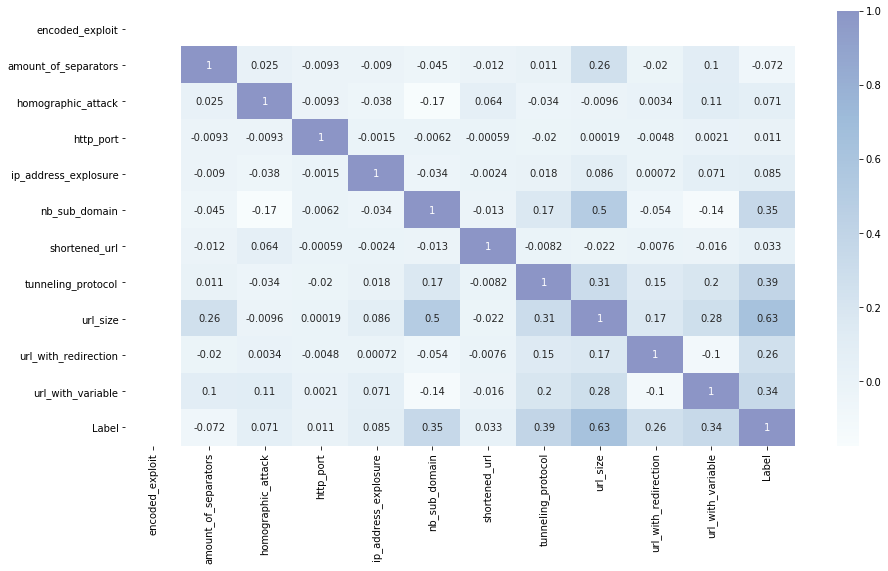

In [16]:
corr_matrix=final_data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix,center=True,annot=True,cmap='BuPu')

In [17]:
X=final_data.iloc[:,1:-1]
y=final_data.Label

## Start building and evaluating models

In [18]:
models=[]
test=[]
train=[]
def saveResult(model,test_acc,train_acc):
    models.append(model)
    test.append(test_acc)
    train.append(train_acc)

In [19]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)

In [21]:
print ('X_train shape: {}\nX_test shape : {}\ny_train shape: {}\ny_test shape : {}'.format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train shape: (7179, 10)
X_test shape : (3536, 10)
y_train shape: (7179,)
y_test shape : (3536,)


### 1- Decision Tree:

In [22]:
clf=DecisionTreeClassifier(max_depth=8)

In [23]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
y_pred = clf.predict(X_test)

In [25]:
print("Accuracy of train:",accuracy_score(y_train, clf.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test, y_pred))
saveResult('Decision Tree',accuracy_score(y_test, y_pred),accuracy_score(y_train, clf.predict(X_train)))

Accuracy of train: 0.9321632539350885
Accuracy of test: 0.917420814479638


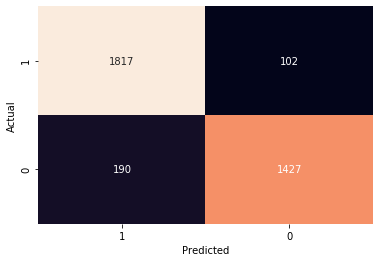

In [26]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), [1,0], [1,0])
sns.heatmap(conf_matrix, annot=True,cbar=False,fmt='.5g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1919
           1       0.93      0.88      0.91      1617

    accuracy                           0.92      3536
   macro avg       0.92      0.91      0.92      3536
weighted avg       0.92      0.92      0.92      3536



### Decision Tree's parameters tunning

In [28]:
"""
params = {'criterion':['gini','entropy'],'max_depth':list(range(2,10)),'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(clf, params, cv=5)
grid_search_cv.fit(X_train, y_train)
clfn=grid_search_cv.best_estimator_
print (clfn)
print("Accuracy of train after tunning:",accuracy_score(y_train, clfn.predict(X_train)))
print("Accuracy of test after tunning:",accuracy_score(y_test,clfn.predict(X_test)))
"""

'\nparams = {\'criterion\':[\'gini\',\'entropy\'],\'max_depth\':list(range(2,10)),\'max_leaf_nodes\': list(range(2, 20)), \'min_samples_split\': [2, 3, 4]}\ngrid_search_cv = GridSearchCV(clf, params, cv=5)\ngrid_search_cv.fit(X_train, y_train)\nclfn=grid_search_cv.best_estimator_\nprint (clfn)\nprint("Accuracy of train after tunning:",accuracy_score(y_train, clfn.predict(X_train)))\nprint("Accuracy of test after tunning:",accuracy_score(y_test,clfn.predict(X_test)))\n'

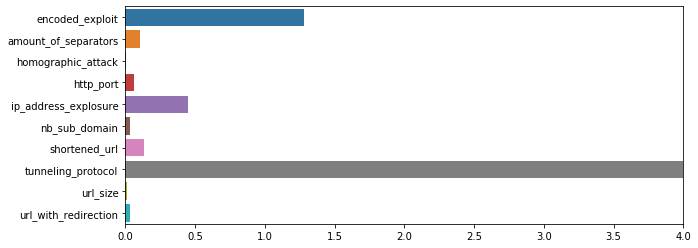

In [29]:
y=10*clf.feature_importances_
x=list(range(0,10))
plt.figure(figsize=(10,4))
sns.barplot(y,x,orient='horizontal')
plt.yticks(x,feature_names)
plt.xlim((0,4))
plt.show()

### 2- Random forest:

Accuracy of train: 0.9304917119375957
Accuracy of test: 0.9256221719457014


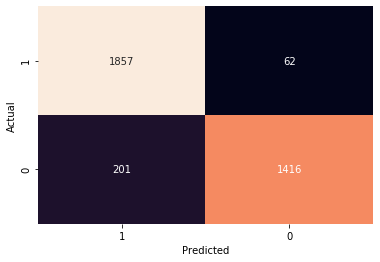

In [30]:
clfr=RandomForestClassifier(n_estimators=100,max_depth=8)
clfr.fit(X_train,y_train)
print("Accuracy of train:",accuracy_score(y_train, clfr.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test,clfr.predict(X_test)))

saveResult('RandomForest',accuracy_score(y_test,clfr.predict(X_test)),accuracy_score(y_train, clfr.predict(X_train)))

conf_matrix = pd.DataFrame(confusion_matrix(y_test,clfr.predict(X_test)), [1,0], [1,0])
sns.heatmap(conf_matrix, annot=True,cbar=False,fmt='.5g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 3- SVM:

In [31]:
clfv = SVC(kernel='linear', C=1.0) # Linear Kernel
clfv.fit(X_train, y_train)
print("Accuracy of train:",accuracy_score(y_train, clfv.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test,clfv.predict(X_test)))

saveResult('SVM',accuracy_score(y_test,clfv.predict(X_test)),accuracy_score(y_train, clfv.predict(X_train)))


Accuracy of train: 0.9100153224683103
Accuracy of test: 0.9063914027149321


### 4- Multi layer perceptron:

In [32]:
from sklearn.neural_network import MLPClassifier
# instantiate the model
mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=([100,100,100]))
# fit the model 
mlp.fit(X_train, y_train)
print("Accuracy of train:",accuracy_score(y_train, mlp.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test,mlp.predict(X_test)))

saveResult('Multi layer perceptron',accuracy_score(y_test,mlp.predict(X_test)),accuracy_score(y_train, mlp.predict(X_train)))


Accuracy of train: 0.917258671124112
Accuracy of test: 0.917420814479638


### 5- XGBoost:

In [33]:
#XGBoost Classification model
from xgboost import XGBClassifier
# instantiate the model
xgb = XGBClassifier(learning_rate=0.1,max_depth=5)
#fit the model
xgb.fit(X_train, y_train)
print("Accuracy of train:",accuracy_score(y_train, xgb.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test,xgb.predict(X_test)))

saveResult('XGBoost',accuracy_score(y_test,xgb.predict(X_test)),accuracy_score(y_train, xgb.predict(X_train)))


Accuracy of train: 0.9314667781027999
Accuracy of test: 0.9222285067873304


### 6- KNN:

In [34]:
knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
print("Accuracy of train:",accuracy_score(y_train, knn.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test,knn.predict(X_test)))

saveResult('Knn',accuracy_score(y_test,knn.predict(X_test)),accuracy_score(y_train,knn.predict(X_train)))

Accuracy of train: 0.9162836049589079
Accuracy of test: 0.9095022624434389


### 7- Logistic regression:

In [35]:
log=LogisticRegressionCV(cv=10,solver='newton-cg')
log.fit(X_train,y_train)
print("Accuracy of train:",accuracy_score(y_train, log.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test,log.predict(X_test)))

saveResult('LogisticReg',accuracy_score(y_test,log.predict(X_test)),accuracy_score(y_train,log.predict(X_train)))

Accuracy of train: 0.9108510934670567
Accuracy of test: 0.9086538461538461


### 8- AdaBoost:

In [36]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train,y_train)
print("Accuracy of train:",accuracy_score(y_train, ada.predict(X_train)))
print("Accuracy of test:",accuracy_score(y_test,ada.predict(X_test)))

saveResult('AdaBoost',accuracy_score(y_test,ada.predict(X_test)),accuracy_score(y_train,ada.predict(X_train)))

Accuracy of train: 0.9169800807911965
Accuracy of test: 0.9120475113122172


In [37]:
result=pd.DataFrame({'Models':models,'Test_accuracy':test,'Train_accuracy':train})
result.sort_values(by=['Test_accuracy'],ascending=False,inplace=True)
result

Models  Test_accuracy  Train_accuracy
1            RandomForest       0.925622        0.930492
4                 XGBoost       0.922229        0.931467
0           Decision Tree       0.917421        0.932163
3  Multi layer perceptron       0.917421        0.917259
7                AdaBoost       0.912048        0.916980
5                     Knn       0.909502        0.916284
6             LogisticReg       0.908654        0.910851
2                     SVM       0.906391        0.910015

# Testing on new data

In [44]:
f=pd.read_csv(r"C:\Users\Amine\Desktop\Nouveau dossier\Test\phishing_urls.csv",names=['URL','label'],header=0,nrows=20)
f['Predlabel']=None
for i in range(0,len(f)):
    sample=Sample(f.iloc[i,0])
    f.iloc[i,2]=urlTypePredict(sample,clfr)
f

URL  label   Predlabel
0   nobell.it/70ffb52d079109dca5664cce6f317373782/...      1    Phishing
1   serviciosbys.com/paypal.cgi.bin.get-into.herf....      1    Phishing
2   mail.printakid.com/www.online.americanexpress....      1  Legitimate
3   thewhiskeydregs.com/wp-content/themes/widescre...      1    Phishing
4                smilesvoegol.servebbs.org/voegol.php      1  Legitimate
5   premierpaymentprocessing.com/includes/boleto-2...      1  Legitimate
6   myxxxcollection.com/v1/js/jih321/bpd.com.do/do...      1    Phishing
7                                 super1000.info/docs      1  Legitimate
8   horizonsgallery.com/js/bin/ssl1/_id/www.paypal...      1    Phishing
9       phlebolog.com.ua/libraries/joomla/results.php      1  Legitimate
10  docs.google.com/spreadsheet/viewform?formkey=d...      1    Phishing
11  www.coincoele.com.br/Scripts/smiles/?pt-br/Pag...      1  Legitimate
12  www.henkdeinumboomkwekerij.nl/language/pdf_fon...      1    Phishing
13  dutchweb.gtphost.com/zimbra/exch/owa/uleth/ind...      1  Legitimate
14              www.avedeoiro.com/site/plugins/chase/      1  Legitimate
15  www.regaranch.info/grafika/file/2012/atualizac...      1    Phishing
16  mercadolivre.com.br.premiosfidelidade2012.com....      1    Phishing
17  mercadolivre.com.br.premiosfidelidade2012.com.br/      1    Phishing
18  www.revitolcream.org/wp-content/plugins/all-in...      1  Legitimate
19  jameshowardmusic.com/wp-content/themes/widescr...      1    Phishing

In [42]:
l=pd.read_csv(r"C:\Users\Amine\Desktop\Nouveau dossier\Test\benign_urls.csv",nrows=20)
l['Predlabel']=None
for i in range(0,len(l)):
    sample=Sample(l.iloc[i,0])
    l.iloc[i,2]=urlTypePredict(sample,clfr)

In [45]:
x = Sample('http://us.diablo.com.zh-yoo.in/login.html?app=wam&ref=https://www.battle.net/account/&eor=0&app=bam')
urlTypePredict(x,clfr)

'Phishing'

In [8]:
import pandas as pd

data = pd.read_csv('~/dev/gitlab/pyphish/data/pyphish_features_set.csv', )

In [9]:
data

0  0.1  0.2  0.3  0.4  0.5  1  0.6  1.1  0.7  1.2
0      0    0    0    1    0    0  1    0    1    0    1
1      0    0    0    1    0    0  1    0    1    0    1
2      0    0    0    1    0    0  1    0    1    0    1
3      0    0    0    1    0    0  1    0    1    0    1
4      0    0    0    1    0    0  1    0    1    0    1
...   ..  ...  ...  ...  ...  ... ..  ...  ...  ...  ...
40014  0    0    0    0    0    0  0    0    1    0    1
40015  0    0    0    0    0    0  0    0    1    0    0
40016  0    0    0    0    0    0  0    0    1    0    0
40017  0    0    0    0    0    0  0    0    1    0    1
40018  0    0    0    0    0    0  0    0    1    0    1

[40019 rows x 11 columns]

In [7]:
data.to_csv("~/net/finaldata_updated.csv", index=False)